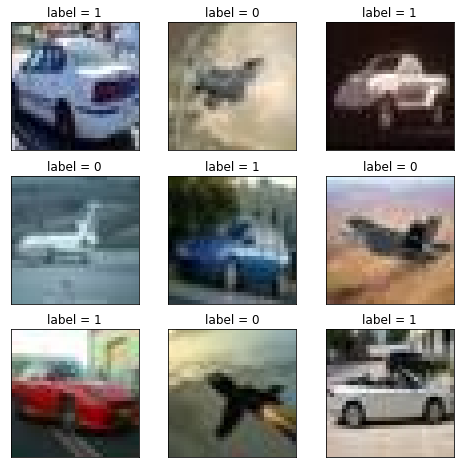

(100, 32, 32, 3) (100,)
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (

Reusing TensorBoard on port 6006 (pid 3776), started 0:03:33 ago. (Use '!kill 3776' to kill it.)

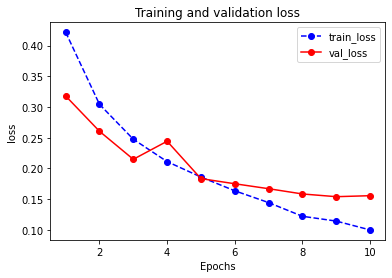

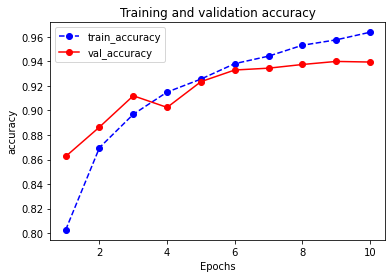

20/20 [==============================] - 0s 15ms/step - loss: 0.1557 - accuracy: 0.9395
0.15571272373199463 0.9394999742507935
[[1.5734828e-03]
 [4.8384815e-04]
 [6.2276653e-05]
 [9.8809844e-01]
 [9.9883574e-01]
 [9.9978250e-01]
 [6.9149578e-06]
 [1.8438780e-01]
 [9.9514091e-01]
 [9.8777032e-01]
 [9.9992919e-01]
 [9.9999249e-01]
 [9.9979848e-01]
 [4.0136736e-05]
 [3.6265034e-02]
 [9.5643909e-06]
 [9.9998224e-01]
 [1.5694826e-03]
 [1.1213596e-03]
 [2.6059831e-02]]


In [2]:
import tensorflow as tf 
from tensorflow.keras import datasets,layers,models
from matplotlib import pyplot as plt
import datetime
import os
from pathlib import Path
from tensorboard import notebook
import pandas as pd

# 加载数据
BATCH_SIZE = 100
def load_image(img_path,size = (32,32)):
    label = tf.constant(1,tf.int8) if tf.strings.regex_full_match(img_path,".*automobile.*") \
            else tf.constant(0,tf.int8)
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img) #注意此处为jpeg格式
    img = tf.image.resize(img,size)/255.0
    return(img,label)

ds_train = tf.data.Dataset.list_files("./datasets/cifar2/train/*/*.jpg") \
           .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
           .shuffle(buffer_size = 1000).batch(BATCH_SIZE) \
           .prefetch(tf.data.experimental.AUTOTUNE)  
ds_test = tf.data.Dataset.list_files("./datasets/cifar2/test/*/*.jpg") \
           .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
           .batch(BATCH_SIZE) \
           .prefetch(tf.data.experimental.AUTOTUNE)

# 可视化数据
plt.figure(figsize=(8,8)) 
for i,(img,label) in enumerate(ds_train.unbatch().take(9)):
    ax=plt.subplot(3,3,i+1)
    ax.imshow(img.numpy())
    ax.set_title("label = %d"%label)
    ax.set_xticks([])
    ax.set_yticks([]) 
plt.show()
for x,y in ds_train.take(1):
    print(x.shape,y.shape)

# 构建模型
tf.keras.backend.clear_session()

inputs = layers.Input(shape=(32,32,3))
x = layers.Conv2D(32,kernel_size=(3,3))(inputs)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(64,kernel_size=(5,5))(x)
x = layers.MaxPool2D()(x)
x = layers.Dropout(rate=0.1)(x)
x = layers.Flatten()(x)
x = layers.Dense(32,activation='relu')(x)
outputs = layers.Dense(1,activation = 'sigmoid')(x)
model = models.Model(inputs = inputs,outputs = outputs)
model.summary()

# 训练
stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = str(Path('./logs/autograph/' + stamp))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.binary_crossentropy,
        metrics=["accuracy"]
    )
history = model.fit(ds_train,epochs= 10,validation_data=ds_test,
                    callbacks = [tensorboard_callback],workers = 4)

# 评估
%load_ext tensorboard
notebook.list()
notebook.start("--logdir=./logs/autograph")

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

plot_metric(history,"loss")
plot_metric(history,"accuracy")
val_loss,val_accuracy = model.evaluate(ds_test,workers=4)
print(val_loss,val_accuracy)

# 使用模型
model.predict(ds_test)
for x,y in ds_test.take(1):
    print(model.predict_on_batch(x[0:20]))
